In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import random
import xgboost
import lightgbm as lgb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV 
#from sklearn.model_selection import cross_val_score,KFold
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Any results you write to the current directory are saved as output.

In [2]:
''' from here  https://www.kaggle.com/c/imet-2019-fgvc6/discussion/87675#latest-516375'''
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything()

In [3]:
train = pd.read_csv('../input/pmp-data-train/train_.csv')
train.drop('molecule_name', axis=1,inplace=True)
train.drop('atom_index_0' , axis=1,inplace=True)
train.drop('atom_index_1' , axis=1,inplace=True)
train.drop('id'           , axis=1,inplace=True)
train.drop(columns="Unnamed: 0",inplace=True)

In [4]:
train.head()

,type,scalar_coupling_constant,type0,charge0,type1,charge1,distance,type_0,charge_0,dist0_0,dist1_0,angle0_0,angle1_0,type_1,charge_1,dist0_1,dist1_1,angle0_1,angle1_1,type_2,charge_2,dist0_2,dist1_2,angle0_2,angle1_2,type_3,charge_3,dist0_3,dist1_3,angle0_3,angle1_3,type_4,charge_4,dist0_4,dist1_4,angle0_4,angle1_4,type_5,charge_5,dist0_5,dist1_5,angle0_5,angle1_5,type_6,charge_6,dist0_6,dist1_6,angle0_6,angle1_6,type_7,charge_7,dist0_7,dist1_7,angle0_7,angle1_7
0,1JHC,84.8076,1.0,0.133921,2.0,-0.535689,1.091953,1.0,0.133923,1.783147,1.091946,35.264217,109.471320,1.0,0.133923,1.783157,1.091948,35.263863,109.472070,1.0,0.133922,1.783120,1.091952,35.265770,109.468410,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
1,2JHH,-11.2570,1.0,0.133921,1.0,0.133922,1.783120,2.0,-0.535689,1.091953,1.091952,35.265770,35.265823,1.0,0.133923,1.783147,1.783158,60.000893,60.000324,1.0,0.133923,1.783157,1.783148,60.000378,60.000840,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
2,2JHH,-11.2548,1.0,0.133921,1.0,0.133923,1.783147,2.0,-0.535689,1.091953,1.091946,35.264217,35.264465,1.0,0.133922,1.783120,1.783158,60.000893,59.998783,1.0,0.133923,1.783157,1.783148,59.999844,60.000336,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
3,2JHH,-11.2543,1.0,0.133921,1.0,0.133923,1.783157,2.0,-0.535689,1.091953,1.091948,35.263863,35.264070,1.0,0.133922,1.783120,1.783148,60.000378,59.998783,1.0,0.133923,1.783147,1.783148,59.999844,59.999820,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
4,1JHC,84.8074,1.0,0.133922,2.0,-0.535689,1.091952,1.0,0.133923,1.783158,1.091946,35.263730,109.472350,1.0,0.133923,1.783148,1.091948,35.264214,109.471420,1.0,0.133921,1.783120,1.091953,35.265823,109.468410,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0


In [5]:
def group_mean_log_mae(y_true, y_pred, floor=1e-9):
    maes = np.absolute(y_true-y_pred).mean()
    return np.log(np.maximum(maes,floor).mean())

In [6]:
def mean_log_mae( y_pred, dataset, floor=1e-9):
    y_true = dataset.get_label()
    maes = np.absolute(y_true-y_pred).mean()
    return 'mean_log_mae', np.log(np.maximum(maes,floor).mean()), False

In [7]:
def show_predictions(true, pred):
    #     print('    actual | prediction | differnece')
    #     for i in range(len(true)):
    #         print('{:10.5f} | {:10.5f} | {:10.5f}'.format(true[i], pred[i], abs(true[i] - pred[i]) ))
    plt.scatter(true,pred)
    plt.show()

In [8]:
??plt.scatter()

Object `plt.scatter()` not found.


In [9]:
files = [ '../input/pmp-lightgbm/model_1JHC.txt',
         '../input/pmp-lightgbm/model_2JHH.txt',
         '../input/pmp-lightgbm/model_1JHN.txt',
         '../input/pmp-lightgbm/model_2JHN.txt',
         '../input/fork-of-pmp-lightgbm/model_2JHC.txt',
         '../input/fork-of-pmp-lightgbm/model_3JHH.txt',
         '../input/fork-of-pmp-lightgbm/model_3JHC.txt',
         '../input/fork-of-pmp-lightgbm/model_3JHN.txt',]

Dataset for type 1JHC has shape (709416, 53)


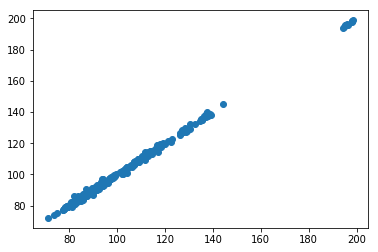

score for type 1JHC  is -------->  -0.5625430329149439
Dataset for type 2JHH has shape (378036, 53)


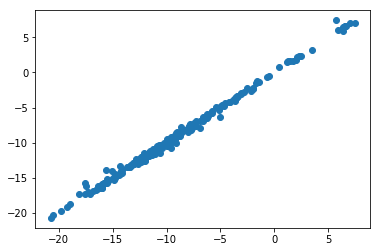

score for type 2JHH  is -------->  -2.061194960115891
Dataset for type 1JHN has shape (43363, 53)


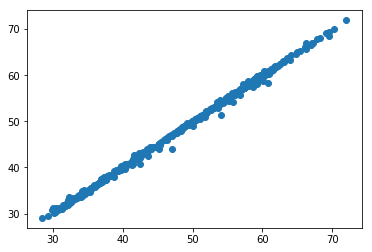

score for type 1JHN  is -------->  -1.5026866055361172
Dataset for type 2JHN has shape (119253, 53)


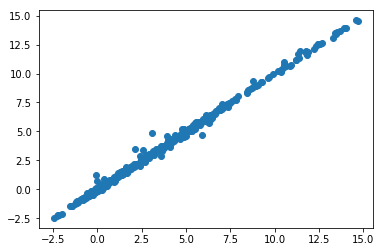

score for type 2JHN  is -------->  -2.3744295726617057
Dataset for type 2JHC has shape (1140674, 53)


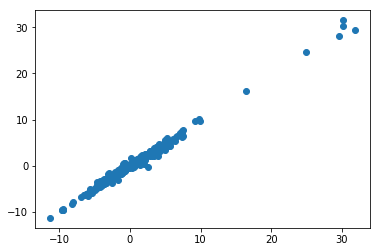

score for type 2JHC  is -------->  -1.4289135609371875
Dataset for type 3JHH has shape (590611, 53)


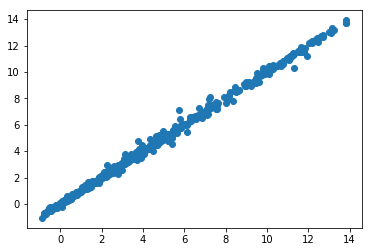

score for type 3JHH  is -------->  -1.926762765385606
Dataset for type 3JHC has shape (1510379, 53)


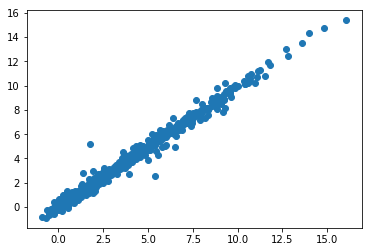

score for type 3JHC  is -------->  -1.3504152515798082
Dataset for type 3JHN has shape (166415, 53)


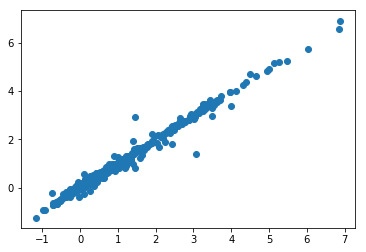

score for type 3JHN  is -------->  -2.6501251769624345


In [10]:
data_fr = {}
models = {}
type_list = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
scores = []
for i,type_ in enumerate(type_list):
    data_fr = train.loc[train['type'] == type_].copy()
    data_fr.reset_index(inplace=True)
    data_fr.drop('type', axis=1,inplace=True)
    data_fr.drop('index', axis=1,inplace=True)
    y =  data_fr.scalar_coupling_constant.values
    data_fr.drop('scalar_coupling_constant', axis=1,inplace=True)
    X =  data_fr.astype(float).values
    features =  data_fr.columns
    print('Dataset for type {} has shape {}'.format(type_,X.shape))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
    reg = lgb.Booster(model_file=files[i])
    show_predictions(y_test[0:500],reg.predict(X_test[0:500]).tolist())
    score = group_mean_log_mae(y_test,reg.predict(X_test))
    scores.append(score)
    models[type_] = reg
    print('score for type {}  is -------->  {}'.format(type_,score))

In [11]:
print('Final score is {}'.format(np.array(scores).mean()))
for i,type_ in enumerate(type_list): print('score of type {} is {}'.format(type_,scores[i]))

Final score is -1.7321338657617118
score of type 1JHC is -0.5625430329149439
score of type 2JHH is -2.061194960115891
score of type 1JHN is -1.5026866055361172
score of type 2JHN is -2.3744295726617057
score of type 2JHC is -1.4289135609371875
score of type 3JHH is -1.926762765385606
score of type 3JHC is -1.3504152515798082
score of type 3JHN is -2.6501251769624345


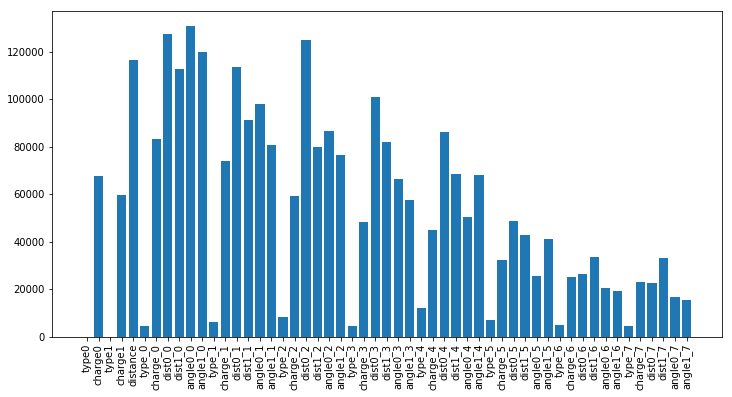

In [12]:
plt.figure(figsize = (12,6))
plt.bar(range(len(reg.feature_importance())), reg.feature_importance())
plt.xticks(range(len(reg.feature_importance())), features, rotation='vertical')
plt.show()

In [13]:
test = pd.read_csv('../input/pmp-data-test/test_.csv')
test.drop('molecule_name', axis=1,inplace=True)
test.drop('atom_index_0' , axis=1,inplace=True)
test.drop('atom_index_1' , axis=1,inplace=True)
test.drop('id'           , axis=1,inplace=True)
test.drop("Unnamed: 0"   , axis=1,inplace=True)

In [14]:
test.head()

,type,type0,charge0,type1,charge1,distance,type_0,charge_0,dist0_0,dist1_0,angle0_0,angle1_0,type_1,charge_1,dist0_1,dist1_1,angle0_1,angle1_1,type_2,charge_2,dist0_2,dist1_2,angle0_2,angle1_2,type_3,charge_3,dist0_3,dist1_3,angle0_3,angle1_3,type_4,charge_4,dist0_4,dist1_4,angle0_4,angle1_4,type_5,charge_5,dist0_5,dist1_5,angle0_5,angle1_5,type_6,charge_6,dist0_6,dist1_6,angle0_6,angle1_6,type_7,charge_7,dist0_7,dist1_7,angle0_7,angle1_7
0,2JHC,1.0,0.207019,2.0,-0.207019,2.261178,2.0,-0.207019,1.062099,1.199079,0.0,0.0,1.0,0.207019,3.323277,1.062099,0.0,180.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
1,1JHC,1.0,0.207019,2.0,-0.207019,1.062099,2.0,-0.207019,2.261178,1.199079,0.0,180.0,1.0,0.207019,3.323277,2.261178,0.0,180.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
2,3JHH,1.0,0.207019,1.0,0.207019,3.323277,2.0,-0.207019,2.261178,1.062099,0.0,0.0,2.0,-0.207019,1.062099,2.261178,0.0,0.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
3,1JHC,1.0,0.207019,2.0,-0.207019,1.062099,2.0,-0.207019,2.261178,1.199079,0.0,180.0,1.0,0.207019,3.323277,2.261178,0.0,180.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
4,2JHC,1.0,0.207019,2.0,-0.207019,2.261178,2.0,-0.207019,1.062099,1.199079,0.0,0.0,1.0,0.207019,3.323277,1.062099,0.0,180.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0


In [15]:
test_ = test.copy()
test_.drop('type', axis=1,inplace=True)
X =  test_.astype(float).values
features = test_.columns
print(X.shape)
test_.head()

(2505542, 53)


,type0,charge0,type1,charge1,distance,type_0,charge_0,dist0_0,dist1_0,angle0_0,angle1_0,type_1,charge_1,dist0_1,dist1_1,angle0_1,angle1_1,type_2,charge_2,dist0_2,dist1_2,angle0_2,angle1_2,type_3,charge_3,dist0_3,dist1_3,angle0_3,angle1_3,type_4,charge_4,dist0_4,dist1_4,angle0_4,angle1_4,type_5,charge_5,dist0_5,dist1_5,angle0_5,angle1_5,type_6,charge_6,dist0_6,dist1_6,angle0_6,angle1_6,type_7,charge_7,dist0_7,dist1_7,angle0_7,angle1_7
0,1.0,0.207019,2.0,-0.207019,2.261178,2.0,-0.207019,1.062099,1.199079,0.0,0.0,1.0,0.207019,3.323277,1.062099,0.0,180.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
1,1.0,0.207019,2.0,-0.207019,1.062099,2.0,-0.207019,2.261178,1.199079,0.0,180.0,1.0,0.207019,3.323277,2.261178,0.0,180.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
2,1.0,0.207019,1.0,0.207019,3.323277,2.0,-0.207019,2.261178,1.062099,0.0,0.0,2.0,-0.207019,1.062099,2.261178,0.0,0.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
3,1.0,0.207019,2.0,-0.207019,1.062099,2.0,-0.207019,2.261178,1.199079,0.0,180.0,1.0,0.207019,3.323277,2.261178,0.0,180.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
4,1.0,0.207019,2.0,-0.207019,2.261178,2.0,-0.207019,1.062099,1.199079,0.0,0.0,1.0,0.207019,3.323277,1.062099,0.0,180.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0


In [16]:
sub = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
sub['scalar_coupling_constant'] = sub['scalar_coupling_constant'].astype(float)

In [17]:
sub.head()

,id,scalar_coupling_constant
0,4658147,0.0
1,4658148,0.0
2,4658149,0.0
3,4658150,0.0
4,4658151,0.0


In [18]:
%%time
from tqdm import tnrange
values = np.zeros(sub.shape[0])
sub['scalar_coupling_constant'] = sub['scalar_coupling_constant'].astype(float)
for i in tnrange(sub.shape[0]):
    type_ = test['type'][i]
    values[i] = models[type_].predict(np.expand_dims(X[i], axis=0))
sub['scalar_coupling_constant'] = pd.DataFrame(np.array(values))

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:195: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


In [19]:
print(sub.head())
sub.to_csv('submission.csv',index=None)

        id  scalar_coupling_constant
0  4658147                 18.002834
1  4658148                193.190463
2  4658149                  9.227583
3  4658150                193.190463
4  4658151                 18.002834


<a href="submission.csv"> Download File </a>

In [20]:
# def tt(j):
#     type_ = test['type'][j]
#     return models[type_].predict(np.expand_dims(X[j], axis=0))    
# def get_dataframe():
#     with Pool(8) as p:
#         a = p.map(tt,[i for i in range(sub.shape[0])])
#     return pd.DataFrame(np.array(a))

In [21]:
# %%time
# sub['scalar_coupling_constant'] = get_dataframe()

In [22]:
# sam['scalar_coupling_constant'] = sam['scalar_coupling_constant'].astype(float)
# for i in range(sam.shape[0]):
#     type_ = test['type'][i]
#     value = preds[type_][i]
#     sam.at[i, 'scalar_coupling_constant'] = value

In [23]:
# parameters_for_testing = {
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.07,0.1,0.5,1],
#    'max_depth':[3,4,5,6],
#    'n_estimators':[10],
#  }

# xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=10, max_depth=6,
#                                  min_child_weight=1, gamma=0, subsample=0.8,
#                                  colsample_bytree=0.8, nthread=6, 
#                                  scale_pos_weight=1, seed=42)

# gsearch = GridSearchCV(estimator = xgb_model, cv=3, param_grid=parameters_for_testing, n_jobs=10,iid=False, verbose=10, scoring='neg_mean_squared_error')
# gsearch.fit(X_train,y_train)
# print('best params')
# print (gsearch.best_params_)
# print('best score')
# print (gsearch.best_score_)

In [24]:
# parameters_for_testing = {
#    'reg_alpha':[0,0.03,0.1,0.3],
#    'reg_labda':[1.5,6,10],
#    'n_estimators':[100],
#  }

# xgb_model = xgboost.XGBRegressor(learning_rate=0.5, 
#                                  n_estimators=100,
#                                  max_depth=6,
#                                  min_child_weight=1.5,
#                                  gamma=0,
#                                  nthread=6, 
#                                  scale_pos_weight=1,
#                                  seed=42)

# gsearch1 = GridSearchCV(estimator = xgb_model, cv=3, param_grid=parameters_for_testing, n_jobs=10,iid=False, verbose=10, scoring='neg_mean_squared_error')
# gsearch1.fit(X_train,y_train)
# print('best params')
# print (gsearch1.best_params_)
# print('best score')
# print (gsearch1.best_score_)

In [25]:
# reg = xgboost.XGBRegressor(
#                              learning_rate=0.5, 
#                              n_estimators=100,
#                              max_depth=6,
#                              min_child_weight=1.5,
#                              gamma=0,
#                              nthread=6, 
#                              scale_pos_weight=1,
#                              reg_alpha=0.3,
#                              reg_lambda=1.5,
#                              seed=42
#                           )
# reg.fit(X_train,y_train);
# print('score is {}'.format(group_mean_log_mae(pd.DataFrame(y_test),pd.DataFrame(reg.predict(X_test)))))

In [26]:
# plt.figure(figsize = (12,6))
# plt.bar(range(len(reg.feature_importances_)), reg.feature_importances_)
# plt.xticks(range(len(reg.feature_importances_)), fea, rotation='vertical')
# plt.show()

In [27]:
# from sklearn import linear_model
# reg = linear_model.RidgeCV()
# reg.fit(X_train, y_train)
# group_mean_log_mae(pd.DataFrame(y_test),pd.DataFrame(reg.predict(X_test)))
# print(y_train[0:5])
# print(reg.predict(X_train[0:5]).tolist())

In [28]:
# from sklearn.svm import SVR
# reg = SVR(gamma='scale', kernel='rbf', max_iter=2000)
# reg.fit(X_train, y_train)
# group_mean_log_mae(pd.DataFrame(y_test),pd.DataFrame(reg.predict(X_test)))

In [29]:
# import torch
# X_trainc = torch.tensor(X_train,dtype=torch.float).cuda()
# Y_trainc = torch.tensor(y_train,dtype=torch.float).cuda() 
# X_testc  = torch.tensor(X_test,dtype=torch.float).cuda()
# Y_testc  = torch.tensor(y_test,dtype=torch.float).cuda()
# class Net(torch.nn.Module):
#     def __init__(self, D_in, D_out):
#         super(Net, self).__init__()
#         self.linear1 = torch.nn.Linear(D_in, 100)
#         self.linear2 = torch.nn.Linear(100, 20)
#         self.linear3 = torch.nn.Linear(20, D_out)
#         self.drop1 = torch.nn.Dropout(p=0.45, inplace=False)
#         self.drop2 = torch.nn.Dropout(p=0.45, inplace=False)
#         self.relu = torch.nn.ReLU()
#     def forward(self, x):
#         x = self.relu(self.linear1(x))
#         x = self.drop1(x)
#         x = self.relu(self.linear2(x))
#         x = self.drop2(x)
#         y_pred = self.linear3(x)
#         return y_pred
# model = Net(44,1).cuda()
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# step = torch.optim.lr_scheduler.StepLR(optimizer,100, gamma = 0.5, last_epoch=-1)
# def acc(model):
#     y_p = model(X_testc).detach().cpu().numpy()
#     print(group_mean_log_mae(pd.DataFrame(y_test),pd.DataFrame(y_p)))
# acc(model)
# model.train()
# for i in range(1501):
#     if i < 310: step.step()
#     model.train()
#     optimizer.zero_grad()
#     y_pred = model(X_testc)
#     loss = criterion(y_pred, Y_testc)
#     loss.backward()
#     optimizer.step()
#     if i%30 == 0: acc(model)

In [30]:
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# def mean_log_mae( y_pred, dataset, floor=1e-9):
#     y_true = dataset.get_label()
#     maes = (pd.DataFrame(y_true)-pd.DataFrame(y_pred)).abs().mean()
#     return 'mean_log_mae', np.log(maes.map(lambda x: max(x, floor))).mean(), False

# def mean_log_mae( y_pred, dataset, floor=1e-9):
#     y_true = dataset.get_label()
#     maes = np.absolute(y_true-y_pred).mean()
#     return np.log(np.maximum(maes,floor).mean())

# params = {
#     'num_leaves'      : [40],
#     'learning_rate'   : [0.2, 0.3, 0.4],
#     'num_boost_round' : [4000]
#  }

# print('Starting training...')
# # train
# reg = lgb.LGBMRegressor(boosting_type ='gbdt',
#                         objective     = 'regression',
#                         verbose_eval  = 200)


# gbm = GridSearchCV(estimator = reg, cv=3, param_grid=params, n_jobs=6, iid=False, verbose=10, scoring='neg_mean_squared_error')

# gbm.fit(X_train, y_train)
# print('best params')
# print (gbm.best_params_)
# print('best score')
# print (gbm.best_score_)